<a href="https://colab.research.google.com/github/vatturisrinivas/op_project/blob/main/Implement_a_Recurrence_Neural_Network_for_Predicting_Sequential_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Install Required Libraries**

In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn


### **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.random import set_seed


### **Set Seed for Reproducibility**

In [ ]:
set_seed(455)
np.random.seed(455)


### **Load and Preview the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload Mastercard_stock_history.csv here

dataset = pd.read_csv("Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"])
dataset = dataset.drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())
print(dataset.describe())


Saving Mastercard_stock_history.csv to Mastercard_stock_history.csv
                               Open      High       Low     Close     Volume
Date                                                                        
2006-05-25 00:00:00-04:00  3.677800  4.202548  3.668674  4.197985  395343000
2006-05-26 00:00:00-04:00  4.225363  4.265517  4.025502  4.100336  103044000
2006-05-30 00:00:00-04:00  4.103990  4.104902  3.910517  4.015467   49898000
2006-05-31 00:00:00-04:00  4.047406  4.139579  4.047406  4.101250   30002000
2006-06-01 00:00:00-04:00  4.100334  4.389630  4.097596  4.335786   62344000
              Open         High          Low        Close        Volume
count  4733.000000  4733.000000  4733.000000  4733.000000  4.733000e+03
mean    157.218445   158.751430   155.650434   157.248719  1.062101e+07
std     151.827873   153.182400   150.433224   151.846666  1.632991e+07
min       3.677800     4.024589     3.668674     4.006337  6.411000e+05
25%      24.703870    25.007020  

In [ ]:
# Forcefully parse and strip time zone from each timestamp string
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert(None)



In [ ]:
print(dataset.index.dtype)


datetime64[ns]


### **Visualize Stock Prices**

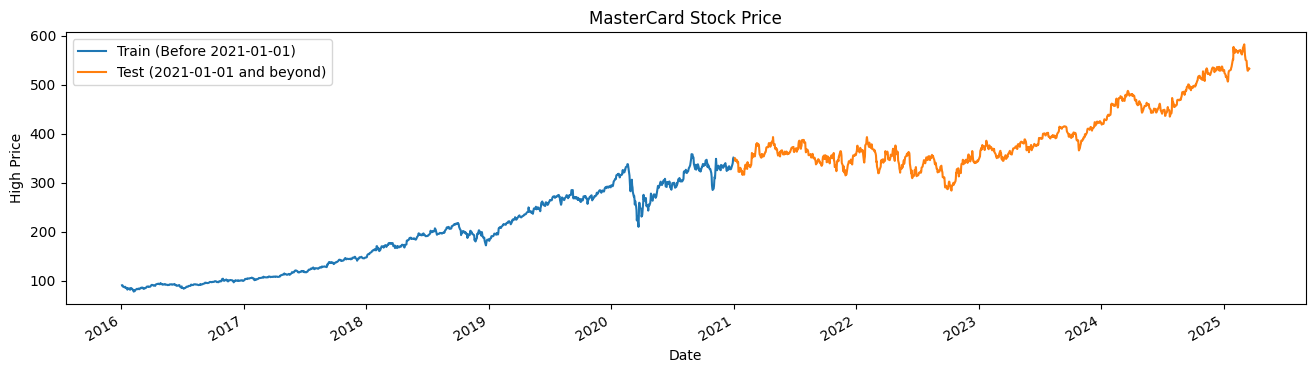

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

tstart = "2016-01-01"
tend = "2020-12-31"

def train_test_plot(dataset, tstart, tend):
    # Convert tend to a datetime object and add 1 day
    test_start = pd.to_datetime(tend) + pd.Timedelta(days=1)

    # Plot training data
    dataset.loc[tstart:tend, "High"].plot(figsize=(16, 4), legend=True)

    # Plot test data starting from the next day
    dataset.loc[test_start:, "High"].plot(figsize=(16, 4), legend=True)

    plt.legend([f"Train (Before {test_start.date()})", f"Test ({test_start.date()} and beyond)"])
    plt.title("MasterCard Stock Price")
    plt.xlabel("Date")
    plt.ylabel("High Price")
    plt.show()

train_test_plot(dataset, tstart, tend)


### **1. Split Data for Training and Testing**

In [ ]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[tstart:tend, "High"].values
    test = dataset.loc[pd.to_datetime(tend) + pd.Timedelta(days=1):, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)



### **2. Normalize (Scale) the Data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)  # Reshape to 2D array for scaler
training_set_scaled = scaler.fit_transform(training_set)


### **3. Create Sequences**

In [ ]:
import numpy as np

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 60
X_train, y_train = create_sequences(training_set_scaled, n_steps)


### **4. Reshape Input for LSTM**

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 1 feature (High price)


### **5. Build and Train the LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(n_steps, 1)))
model.add(Dense(1))  # Predict one value (next day price)

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=5, batch_size=32)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0761
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.5381e-04
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.4368e-04
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.3452e-04


### **6. Prepare Test Data and Predict**

In [ ]:
total_dataset = dataset["High"].values
inputs = total_dataset[len(total_dataset) - len(test_set) - n_steps:]
inputs = inputs.reshape(-1, 1)
inputs_scaled = scaler.transform(inputs)

X_test, y_test = create_sequences(inputs_scaled, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


### **7.** **Visualize and Evaluate**

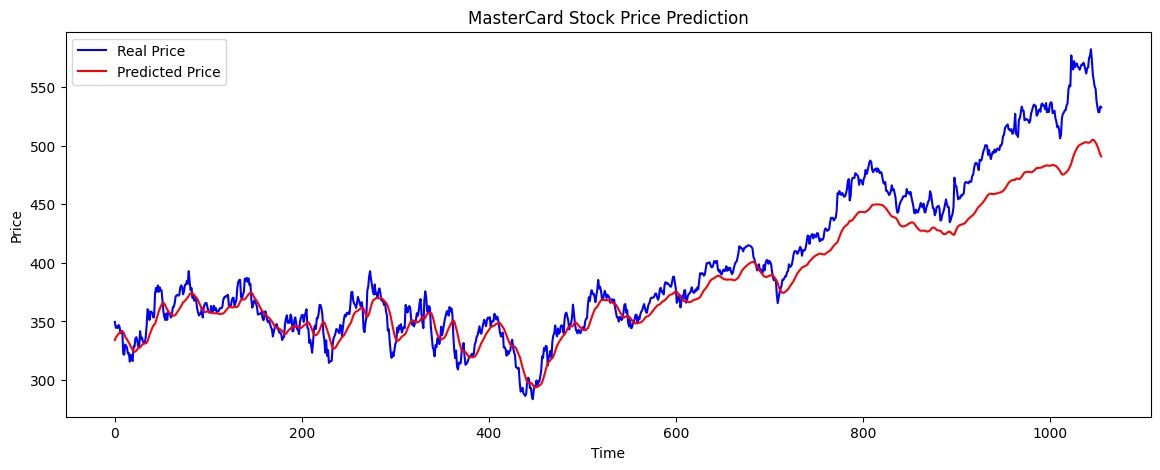

Root Mean Squared Error: 23.22


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

plt.figure(figsize=(14,5))
plt.plot(test_set, color='blue', label='Real Price')
plt.plot(predicted_prices, color='red', label='Predicted Price')
plt.title('MasterCard Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(test_set, predicted_prices))
print(f'Root Mean Squared Error: {rmse:.2f}')
